In [1]:
# Settings for autoreloading.

%load_ext autoreload
%autoreload 2

In [2]:
import wandb


wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: riccardo-spolaor94 (ai-industry). Use `wandb login --relogin` to force relogin


True

In [3]:
from src.model import get_model_dictionary

models = [
    'cloud-diffuser-baseline',
    'cloud-diffuser-baseline-no-autoregression',
    'cloud-diffuser-baseline-autoregression'
]
models_artifacts = { m: 'unet_small:latest' for m in models }
models_dictionaries = { m: get_model_dictionary(v, m) for m, v in models_artifacts.items() }

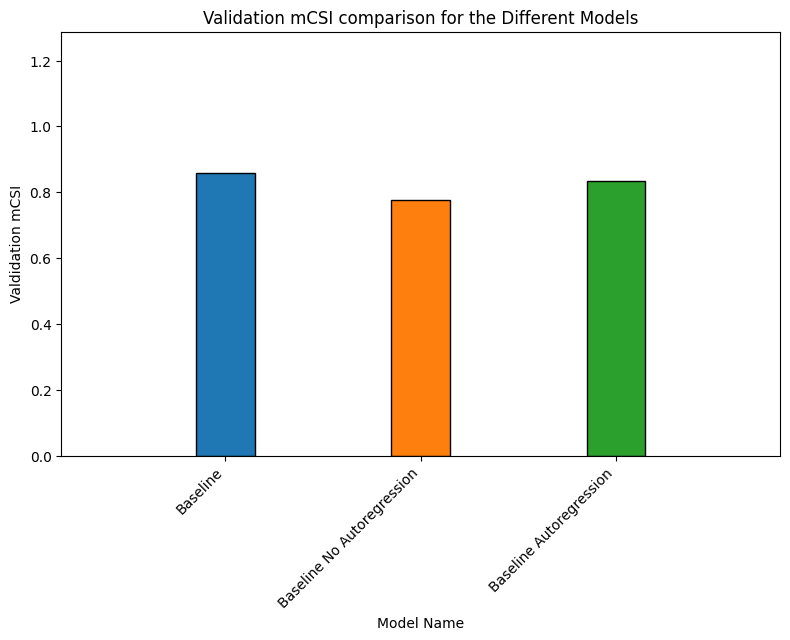

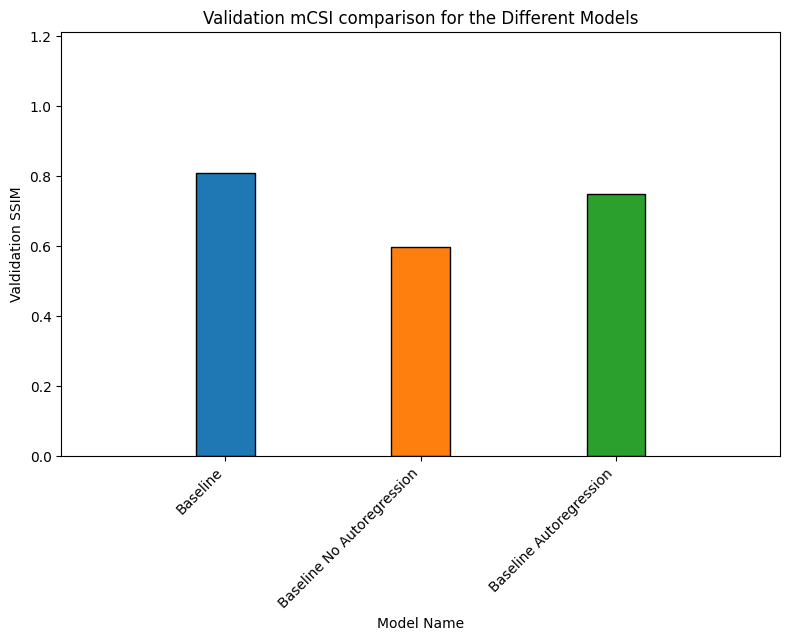

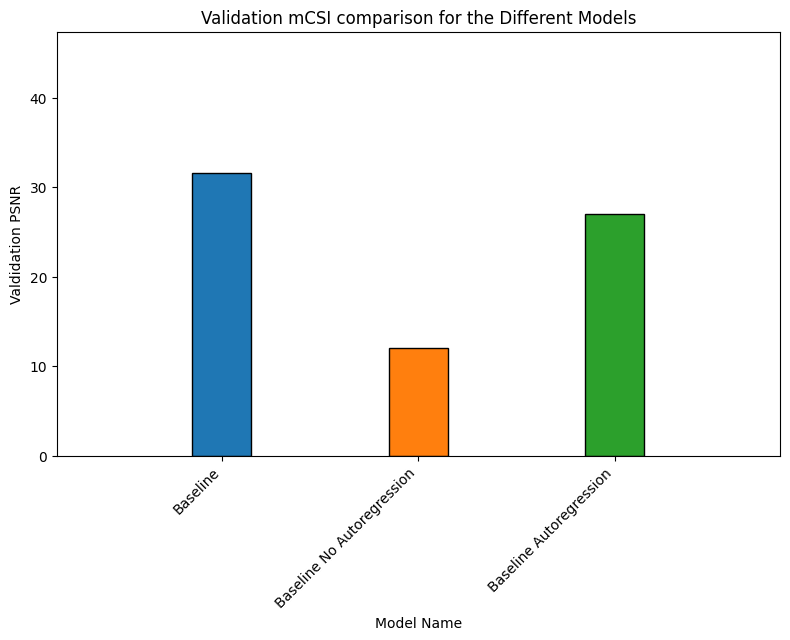

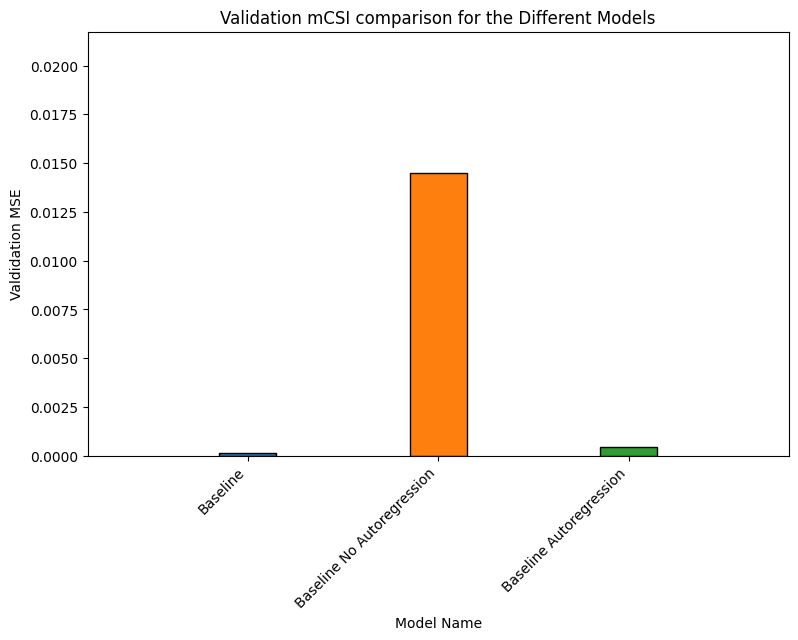

In [4]:
from src.visualization import plot_metric

plot_metric('val_m_csi', 'mCSI', models_dictionaries)
plot_metric('val_ssim', 'SSIM', models_dictionaries)
plot_metric('val_psnr', 'PSNR', models_dictionaries)
plot_metric('val_mse', 'MSE', models_dictionaries)

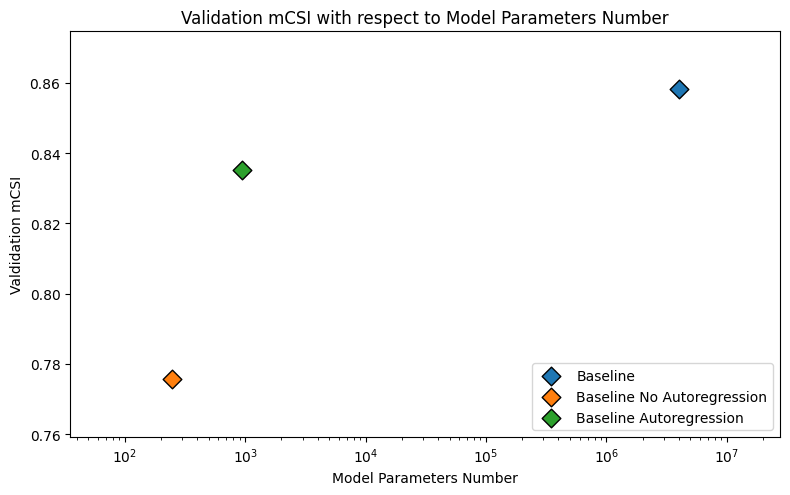

In [5]:
from src.visualization import plot_model_parameters_vs_m_csi

plot_model_parameters_vs_m_csi(models_dictionaries)